# Problem 2: Getting familiar with TensorFlow

*TensorFlow* is one of the most popular deep learning framework developed by Google. If you are new to TensorFlow, please read and play with the sample in [Getting started with TensorFlow](https://www.tensorflow.org/get_started/get_started) to get started.

* <b>Learning Objective:</b> In Problem 1, you implemented a fully connected network from scratch on your own. Very tedious to do it all by yourself, right? Well, we actually feel the same thing, that's why we are using tools instead of doing everything from scratch. For this part of the assignment, we will familiarize you with a widely-used deep learning framework developed by Google, TensorFlow and walk you through convolutional neural networks and show how to train them.
* <b>Provided Codes:</b> We provide the Template class for a simple CNN model as BaseModel, predefined skeletons for conv2d() and max_pool(), as well as the dataset preprocessing parts.
* <b>TODOs:</b> You are asked to implement the BaseModel following the detailed instructions and design your own model in YourModel to achieve a reasonably good performance for classification task on CIFAR-10 dataset.

## Import libraries

In [6]:
# Import required libraries
# Add whatever you want
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from lib.datasets import CIFAR10_tf

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("TensorFlow Version {}".format(tf.__version__))

TensorFlow Version 1.12.0


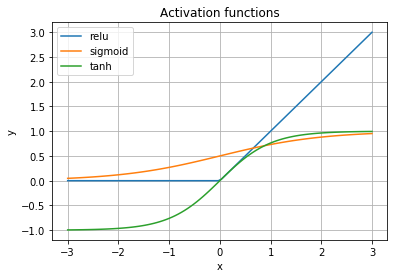

In [7]:
# Test matplotlib
x = np.linspace(-3, 3, 100)

plt.plot(x, np.maximum(0, x), label='relu')
plt.plot(x, 1/(1 + np.exp(-x)), label='sigmoid')
plt.plot(x, (1 - np.exp(-2 * x))/(1 + np.exp(-2 * x)), label='tanh')

plt.xlabel('x')
plt.ylabel('y')

plt.title("Activation functions")
plt.legend()
plt.grid(True)

plt.show()

In [8]:
# Test tensorflow
print('TensorFlow version: ' + tf.__version__)
a = tf.constant(2.0)
b = tf.constant(3.0)
c = a * b

sess = tf.Session()
result = sess.run([a, b, c])
print('%f * %f = %f' % (result[0], result[1], result[2]))
sess.close()

TensorFlow version: 1.12.0
2.000000 * 3.000000 = 6.000000


## Load datasets
Download [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) and load the dataset. In this assignment, we will use the standard 50,000 images for training and 10,000 images for test.

In [9]:
# Configuration
num_training = 49000
num_validation = 50000 - num_training
num_test = 10000

data = CIFAR10_tf(num_training=num_training,
                  num_validation=num_validation,
                  num_test=num_test)

# Load cifar-10 data
X_train, Y_train = data['data_train'], data['labels_train']
X_val, Y_val = data['data_val'], data['labels_val']
X_test, Y_test = data['data_test'], data['labels_test']

# Check the shape of the dataset
assert X_train.shape == (num_training, 32, 32, 3)
assert Y_train.shape == (num_training, )
assert X_val.shape == (num_validation, 32, 32, 3)
assert Y_val.shape == (num_validation, )
assert X_test.shape == (num_test, 32, 32, 3)
assert Y_test.shape == (10000, )

## Question 2-1

Using the code provided, implement a neural network architecture with an optimization routine according to the specification provided below.

**Model:**
- Input image with the size 32x32x3
- 7x7 convolutional layer with 32 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- 5x5 convolutional layer with 64 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- Flatten layer (8x8x64 -> 4096)
- Fully-connected layer with 384 output units (4096 -> 384)
- ReLU activation layer
- Fully-connected layer with 10 output units (384 -> 10)
- Output logits (10)

**Optimizer:**
- Adam optimizer

**Learning rate:**
- Set start learning rate as 5e-4 and apply exponential decay every 500 steps with a base of 0.96
- Use 'tf.train.exponential_decay' and 'tf.train.AdamOptimizer'

**Loss:**
- Softmax cross entropy loss
- Use 'tf.nn.softmax_cross_entropy_with_logits'


Your model **should** achieve about 60% accuracy on validation set in 5 epochs using provided evaluation code.

You can modify the template code as you want.

## Define your layers

In [10]:
# Define max pooling and conv layers

def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

#############################################################################
# TODO: Complete the following functions                                    #
#############################################################################
def flatten(input):
    """
        - input: input tensors
    """
    return tf.layers.flatten(input)

def fc(input, num_output):
    """
        - input: input tensors
        - num_output: int, the output dimension
    """
    return tf.layers.dense(input, num_output)

def norm(input, is_training):
    """
        - input: input tensors
        - is_training: boolean, if during training or not
    """
    # Is this input normalization or batch normalization??
    return tf.layers.batch_normalization(input, training = is_training)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## Sample convolutional neural network

In [11]:
# Helper class to define hyper parameters so that I can test 
# different combinations to run the learning phases (train / validate / test).
# This class only exposes options like a config, it's upto the model implementation
# class to use/ignore those options.
class Options:
    def __init__(self, num_cnn=2, num_fc=2, use_dropout=False, use_batch_norm=False, num_epoch=10, lrDecay=None):
        self.num_cnn = num_cnn
        self.num_fc = num_fc
        self.use_dropout = use_dropout
        self.use_batch_norm = use_batch_norm #TODO: Not handled in YourModel class yet
        self.num_epoch = num_epoch
        self.lrDecay = lrDecay #TODO: Not handled in YourModel class yet
        
    def __str__(self):
        return str.format("num_cnn = {}, num_fc = {}, use_dropout = {}, use_batch_norm = {}, num_epoch = {}, lrDecay = {}",
                         self.num_cnn, self.num_fc, self.use_dropout, self.use_batch_norm, self.num_epoch, self.lrDecay)
        

In [28]:
class BaseModel(object):
    def __init__(self, options):
        self.options = options #Base class does not use this for now, meant for child class
        self.num_epoch = 5
        self.batch_size = 128
        self.log_step = 50
        self._build_model()

    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2)                        
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv2 layer: ' + str(self.pool2.get_shape()))

        #############################################################################
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        self.flat = flatten(self.pool2)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc3 = fc(self.flat, 384)
            self.relu3 = tf.nn.relu(self.fc3)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc3 layer: ' + str(self.relu3.get_shape()))
            
        with tf.variable_scope('fc4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc4 = fc(self.relu3, 10)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc4 layer: ' + str(self.fc4.get_shape()))
            
        # Return the last layer
        return self.fc4

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])

        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################
        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        global_step = tf.Variable(0, trainable=False)        
        learning_rate = tf.train.exponential_decay(5e-4, global_step, 500, 0.96)        
        self.train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss_op)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def _loss(self, labels, logits):
        # Softmax cross entropy loss 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        self.loss_op = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                #############################################################################
                # TODO: You can change feed data as you want                                #
                #############################################################################
                feed_dict = {self.X: X_, self.Y: Y_}
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))
            
        #############################################################################
        # TODO: Plot training curve                                                 #
        #############################################################################
        # Graph 1. X: epoch, Y: training loss
        plt.plot(range(self.num_epoch * (num_training // self.batch_size)), losses, label='Training Loss')

        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.title("Loss")
        plt.legend()
        
        plt.show()        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
            
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = {self.X: X_, self.Y: Y_}
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 1877.948, accuracy = 0.125
iteration (50): loss = 279.779, accuracy = 0.164
iteration (100): loss = 248.671, accuracy = 0.359
iteration (150): loss = 221.350, accuracy = 0.352
iteration (200): loss = 218.594, accuracy = 0.438
iteration (250): loss = 221.122, accuracy = 0.375
iteration (300): loss = 210.745, accuracy = 0.438
iteration (350): loss = 213.784, accuracy = 0.383
validation for epoch 0
-  epoch 0: validation accuracy = 0.499
train for epoch 1
iteration (400): loss = 180.839, accuracy = 0.477
iteration (450): loss = 183.483, accuracy = 0.508
iteration (500): loss = 184.288, accuracy = 0.461
iteration (550): loss = 151.696, accuracy = 0.617
iteration (600): loss = 181.037, accuracy = 0.500
iteration (650): loss = 192.425, accuracy = 0.469
i

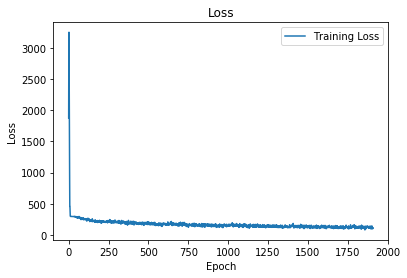

***** test accuracy: 0.627
Model saved in lib/tf_models/problem2/csci-599_sample.ckpt


In [39]:
# Clear old computation graphs
tf.reset_default_graph()

# Train our sample model
with tf.Session() as sess:
    with tf.device('/cpu:0'):
        model = BaseModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_sample.ckpt")
        print("Model saved in %s" % model_path)

## Question 2-2

Implement your own model. 

You can modify the template code as you want and you can use GPU for fast training.  
For GPU usage, simply change the following line of the training block:  
from `with tf.device('/cpu:0')` to `with tf.device('/GPU:0')`  
and you can set your desired device number  

These are the techniques that you can try:
- Data preprocessing
- Data augmentation
- Dropout
- Batch normalization
- More convolutional layers
- More training epochs
- Learning rate decay
- Any other models and techniqes

Your model should achieve >= 70% accuracy on the test set of CIFAR-10.

If the accuracy of the model reaches to 80%, you will get 5 extra points.

In [27]:
class YourModel(BaseModel):
    def __init__(self, options):
        super(YourModel, self).__init__(options)
        self.num_epoch = options.num_epoch

    def _model(self):
        options = self.options
        
        print('-' * 5 + '  Your model  ' + '-' * 5)

        #############################################################################
        # TODO: Implement you own model here                                        #
        #############################################################################        
        print('-' * 5 + '  Sample model  ' + '-' * 5)
        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2)                        
            print('conv2 layer: ' + str(self.pool2.get_shape()))
            last_conv = self.pool2
        
        if (options.num_cnn >= 3):
            with tf.variable_scope('conv3'):
                self.conv3 = conv2d(self.pool2, 5, 1, 64)
                self.relu3 = tf.nn.relu(self.conv3)
                self.pool3 = max_pool(self.relu3, 3, 2)                        
                print('conv3 layer: ' + str(self.pool3.get_shape()))
                last_conv = self.pool3

        if (options.num_cnn >= 4):
            with tf.variable_scope('conv4'):
                self.conv4 = conv2d(self.pool3, 3, 1, 128)
                self.relu4 = tf.nn.relu(self.conv4)
                self.pool4 = max_pool(self.relu4, 3, 2)                        
                print('conv4 layer: ' + str(self.pool4.get_shape()))
                last_conv = self.pool4

        if (options.num_cnn >= 5):
            with tf.variable_scope('conv5'):
                self.conv5 = conv2d(self.pool4, 3, 1, 128)
                self.relu5 = tf.nn.relu(self.conv5)
                self.pool5 = max_pool(self.relu5, 3, 1)                        
                print('conv5 layer: ' + str(self.pool5.get_shape()))
                last_conv = self.pool5
                
#         if (options.use_dropout):
#             last_conv = tf.nn.dropout(last_conv, 0.1)

        self.flat = flatten(last_conv)
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc6'):
            self.fc6 = fc(self.flat, 384)
            self.relu6 = tf.nn.relu(self.fc6)
            print('fc6 layer: ' + str(self.relu6.get_shape()))
            last_fc = self.relu6
            
        if (options.use_dropout):
            last_fc = tf.nn.dropout(last_fc, 0.5)

        if (options.num_fc >= 3):
            with tf.variable_scope('fc7'):
                self.fc7 = fc(last_fc, 192)
                self.relu7 = tf.nn.relu(self.fc7)
                print('fc7 layer: ' + str(self.relu7.get_shape()))            
                last_fc = self.relu7
            
        if (options.use_dropout):
            last_fc = tf.nn.dropout(last_fc, 0.5)

        with tf.variable_scope('fc8'):
            self.fc8 = fc(last_fc, 10)
            print('fc8 layer: ' + str(self.fc8.get_shape()))
            
        # Return the last layer
        return self.fc8
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

In [31]:
# Making a function out of the block below to try a few hyper paramter combinations
# (so that I can keep the system running while I am doing something else)
def reset_and_train(options):
    print (str.format("Learning started with options : {}", options))
    # Clear old computation graphs
    tf.reset_default_graph()

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
        with tf.device('/gpu:0'):
            model = YourModel(options)
            model.train(sess, X_train, Y_train, X_val, Y_val)
            accuracy = model.evaluate(sess, X_test, Y_test)
            print('***** test accuracy: %.3f' % accuracy)

-----  Your model  -----
-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
conv3 layer: (?, 4, 4, 64)
conv4 layer: (?, 2, 2, 128)
conv5 layer: (?, 1, 1, 128)
flat layer: (?, 128)
fc6 layer: (?, 384)
fc7 layer: (?, 192)
fc8 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 309.789, accuracy = 0.133
iteration (50): loss = 239.628, accuracy = 0.352
iteration (100): loss = 210.183, accuracy = 0.406
iteration (150): loss = 197.522, accuracy = 0.398
iteration (200): loss = 179.606, accuracy = 0.516
iteration (250): loss = 184.133, accuracy = 0.539
iteration (300): loss = 162.032, accuracy = 0.547
iteration (350): loss = 179.236, accuracy = 0.438
validation for epoch 0
-  epoch 0: validation accuracy = 0.565
train for epoch 1
iteration (400): loss = 164.694, accuracy = 0.453
iteration (450): loss = 156.584, accuracy = 0.555
iteration (500): loss = 139.910, accuracy = 0.547
iteration (550): loss = 1

-  epoch 16: validation accuracy = 0.712
train for epoch 17
iteration (6500): loss = 50.494, accuracy = 0.867
iteration (6550): loss = 45.278, accuracy = 0.883
iteration (6600): loss = 34.867, accuracy = 0.914
iteration (6650): loss = 55.998, accuracy = 0.812
iteration (6700): loss = 35.474, accuracy = 0.914
iteration (6750): loss = 49.718, accuracy = 0.844
iteration (6800): loss = 28.767, accuracy = 0.922
iteration (6850): loss = 50.342, accuracy = 0.859
validation for epoch 17
-  epoch 17: validation accuracy = 0.699
train for epoch 18
iteration (6900): loss = 48.112, accuracy = 0.852
iteration (6950): loss = 44.342, accuracy = 0.859
iteration (7000): loss = 55.683, accuracy = 0.844
iteration (7050): loss = 51.886, accuracy = 0.867
iteration (7100): loss = 44.874, accuracy = 0.852
iteration (7150): loss = 48.480, accuracy = 0.852
iteration (7200): loss = 42.957, accuracy = 0.891
iteration (7250): loss = 47.570, accuracy = 0.883
validation for epoch 18
-  epoch 18: validation accuracy

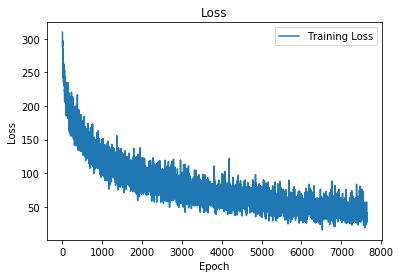

***** test accuracy: 0.703
Model saved in lib/tf_models/problem2/csci-599_mine.ckpt


In [21]:
# Clear old computation graphs
tf.reset_default_graph()

# Hyper parameters that achieve 70% test accuracy
# (dropout did not have a major impact on final test accuracy - may be my implementation needs improvement)
options = Options(num_cnn = 5, use_dropout = False, num_fc = 3, num_epoch = 20)

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
    with tf.device('/cpu:0'):
        model = YourModel(options)
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        # Save your model
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")
        print("Model saved in %s" % model_path)

Learning started with options : num_cnn = 5, num_fc = 3, use_dropout = False, use_batch_norm = False, num_epoch = 20, lrDecay = None
-----  Your model  -----
-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
conv3 layer: (?, 4, 4, 64)
conv4 layer: (?, 2, 2, 128)
conv5 layer: (?, 2, 2, 128)
flat layer: (?, 512)
fc6 layer: (?, 384)
fc7 layer: (?, 192)
fc8 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 335.983, accuracy = 0.156
iteration (50): loss = 247.107, accuracy = 0.289
iteration (100): loss = 214.568, accuracy = 0.398
iteration (150): loss = 194.182, accuracy = 0.438
iteration (200): loss = 196.448, accuracy = 0.461
iteration (250): loss = 196.559, accuracy = 0.398
iteration (300): loss = 169.157, accuracy = 0.539
iteration (350): loss = 169.547, accuracy = 0.492
validation for epoch 0
-  epoch 0: validation accuracy = 0.551
train for epoch 1
iteration (400): loss = 155.339, accuracy 

iteration (6400): loss = 58.394, accuracy = 0.836
iteration (6450): loss = 47.388, accuracy = 0.867
validation for epoch 16
-  epoch 16: validation accuracy = 0.682
train for epoch 17
iteration (6500): loss = 59.345, accuracy = 0.797
iteration (6550): loss = 48.217, accuracy = 0.828
iteration (6600): loss = 71.153, accuracy = 0.797
iteration (6650): loss = 30.380, accuracy = 0.914
iteration (6700): loss = 42.444, accuracy = 0.891
iteration (6750): loss = 64.083, accuracy = 0.844
iteration (6800): loss = 49.506, accuracy = 0.867
iteration (6850): loss = 60.463, accuracy = 0.867
validation for epoch 17
-  epoch 17: validation accuracy = 0.708
train for epoch 18
iteration (6900): loss = 43.562, accuracy = 0.859
iteration (6950): loss = 57.419, accuracy = 0.867
iteration (7000): loss = 66.017, accuracy = 0.836
iteration (7050): loss = 43.179, accuracy = 0.875
iteration (7100): loss = 61.245, accuracy = 0.828
iteration (7150): loss = 43.781, accuracy = 0.883
iteration (7200): loss = 64.452,

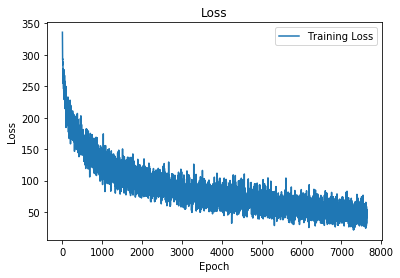

***** test accuracy: 0.706


In [30]:
reset_and_train(Options(num_cnn = 5, use_dropout = False, num_fc = 3, num_epoch = 20))

In [ ]:
tf.reset_default_graph()

# Load your model
model = YourModel()
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")